In [3]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Dataset de Tesla

In [4]:
#Guarda los valores de una accion en particular(ticke), de un periodo de tiempo en un dataframe
#este caso es el Standard & Poor's 500 - S&P500
apple_10y = yf.Ticker("AAPL").history(period="10y")

#Mestra la cabecera del dataframe
apple_10y.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-15 00:00:00-04:00,22.821444,22.874720,22.517337,22.559511,245266000,0.0,0.0
2014-09-16 00:00:00-04:00,22.153287,22.477373,21.951288,22.388582,267632400,0.0,0.0
2014-09-17 00:00:00-04:00,22.479589,22.597238,22.328645,22.548403,243706000,0.0,0.0
2014-09-18 00:00:00-04:00,22.626095,22.719325,22.543963,22.595018,149197600,0.0,0.0
2014-09-19 00:00:00-04:00,22.706011,22.719330,22.308673,22.410782,283609600,0.0,0.0


In [5]:
# Fijamos la semilla para asegurar que los resultados de las operaciones aleatorias sean reproducibles.
np.random.seed(4)

# Dividimos los datos en un conjunto de entrenamiento (hasta el año 2022) y un conjunto de validación (a partir de 2023).
# Usamos solo la segunda columna del dataset (habitualmente el precio de cierre ajustado).
set_entrenamiento = apple_10y[:'2022'].iloc[:, 1:2]
set_validacion = apple_10y['2023':].iloc[:, 1:2]

# Escalamos los datos de entrenamiento para que estén en el rango de 0 a 1.
# Esto es importante para mejorar el rendimiento de los algoritmos de machine learning.
sc = MinMaxScaler(feature_range=(0, 1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

# Definimos la longitud de la ventana de tiempo (60 días).
time_step = 60
X_train = []  # Lista para almacenar las secuencias de entrada.
Y_train = []  # Lista para almacenar los valores objetivo.
m = len(set_entrenamiento_escalado)  # Número total de datos en el conjunto de entrenamiento escalado.

# Creamos las secuencias de entrada (X_train) y los valores objetivo (Y_train).
# Para cada ventana de 60 días (time_step), el valor objetivo es el día siguiente.
for i in range(time_step, m):
    # La secuencia de entrada X: contiene datos de 60 días previos.
    X_train.append(set_entrenamiento_escalado[i-time_step:i, 0])

    # El valor objetivo Y: el valor del día siguiente.
    Y_train.append(set_entrenamiento_escalado[i, 0])

# Convertimos las listas a arrays numpy para que puedan ser usados por TensorFlow.
X_train, Y_train = np.array(X_train), np.array(Y_train)

# Reestructuramos X_train para que tenga la forma adecuada para el modelo LSTM: (n_samples, time_steps, n_features).
# Donde n_samples es el número de muestras, time_steps es la longitud de la secuencia, y n_features es el número de características (en este caso, 1).
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Definimos las dimensiones de entrada y salida para la LSTM.
dim_entrada = (X_train.shape[1], 1)  # Entrada con 60 pasos de tiempo y 1 característica.
dim_salida = 1  # Salida de una sola variable (el valor predicho).

# Definimos el número de neuronas en la capa LSTM.
na = 50

# Creamos el modelo secuencial.
modelo = Sequential()

# Añadimos una capa LSTM con 'na' neuronas y la forma de entrada especificada.
modelo.add(LSTM(units=na, input_shape=dim_entrada))

# Añadimos una capa densa de salida con una única neurona, ya que estamos prediciendo un solo valor.
modelo.add(Dense(units=dim_salida))

# Compilamos el modelo usando el optimizador RMSprop y la función de pérdida MSE (error cuadrático medio).
# MSE es apropiado para tareas de regresión.
modelo.compile(optimizer='rmsprop', loss='mse')

# Entrenamos el modelo con el conjunto de entrenamiento durante 20 épocas, usando un tamaño de lote de 32.
modelo.fit(X_train, Y_train, epochs=20, batch_size=32)

# Para las predicciones, tomamos los valores del conjunto de validación.
x_test = set_validacion.values

# Escalamos los datos de validación para que estén en el mismo rango que los de entrenamiento.
x_test = sc.transform(x_test)

# Creamos las secuencias de entrada (X_test) para el conjunto de validación.
X_test = []
for i in range(time_step, len(x_test)):
    # Para cada ventana de 60 días en los datos de validación.
    X_test.append(x_test[i-time_step:i, 0])

# Convertimos la lista a un array numpy.
X_test = np.array(X_test)

# Reestructuramos X_test a la forma adecuada para la LSTM: (n_samples, time_steps, n_features).
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Realizamos predicciones usando el modelo entrenado.
prediccion = modelo.predict(X_test)

# Invertimos la escala de las predicciones para devolverlas a su rango original (antes de escalar).
prediccion = sc.inverse_transform(prediccion)


c:\Users\jrgui\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0206
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0014
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 9.4156e-04
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 8.1419e-04
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 6.5769e-04
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 6.0575e-04
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 5.7428e-04
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 4.5213e-04
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 4.5682e-04
Epoch 10/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 3.6997e-04
Epoch 11/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 4.3947e-04
Epoch 12/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 5.1198e-04
Epoch 13/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 4.0889e-04
Epoch 14/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 3.5050e-04
Epoch 15/20
64/64 ━━━━━

c:\Users\jrgui\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


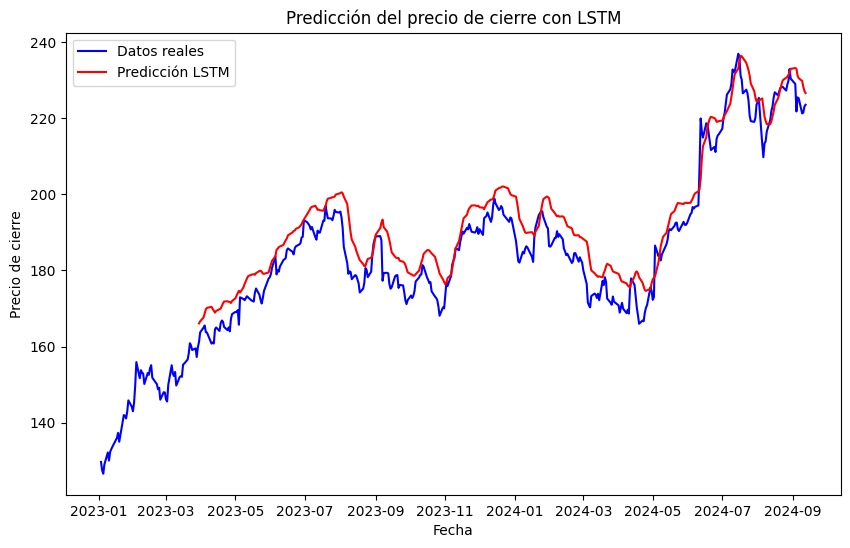

In [6]:
# Añadimos una nueva columna 'Prediccion' al conjunto de validación, inicializando sus valores como NaN.
# Esto nos permitirá almacenar las predicciones del modelo en la misma estructura de los datos de validación.
set_validacion['Prediccion'] = np.nan

# Asignamos las predicciones hechas por el modelo a la columna 'Prediccion' a partir del índice time_step.
# De esta manera, las predicciones se alinean con los datos reales en el tiempo.
set_validacion['Prediccion'].iloc[time_step:] = prediccion.flatten()

# Gráfico 1: Datos reales de validación vs predicción
# Este gráfico compara los precios reales con las predicciones hechas por el modelo LSTM.
plt.figure(figsize=(10,6))  # Definimos el tamaño de la figura.

# Graficamos los datos reales de validación.
plt.plot(set_validacion.index, set_validacion.iloc[:, 0], color='blue', label='Datos reales')

# Graficamos las predicciones del modelo LSTM.
plt.plot(set_validacion.index, set_validacion['Prediccion'], color='red', label='Predicción LSTM')

# Añadimos título y etiquetas a los ejes del gráfico.
plt.title('Predicción del precio de cierre con LSTM')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre')

# Añadimos una leyenda para identificar cada curva.
plt.legend()

# Mostramos el gráfico.
plt.show()



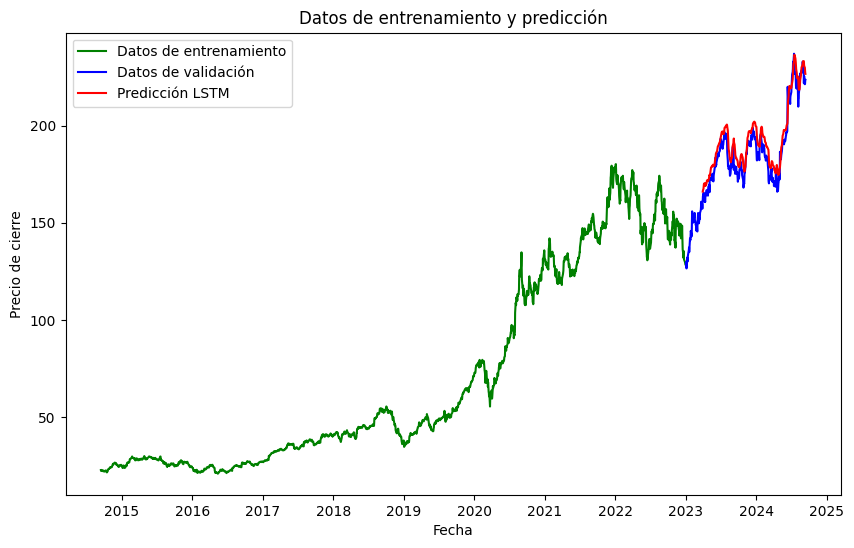

In [7]:
# Gráfico 2: Datos de entrenamiento, datos de validación, y predicciones
# En este gráfico combinamos los datos de entrenamiento y validación con las predicciones.

# Definimos el tamaño del conjunto de entrenamiento y validación.
train_size = len(set_entrenamiento)
valid_size = len(set_validacion)

# Combinamos los datos de entrenamiento y validación en un solo dataframe para que se puedan graficar juntos.
dataset_total = pd.concat([set_entrenamiento, set_validacion], axis=0)

plt.figure(figsize=(10,6))  # Definimos el tamaño de la figura.

# Graficamos los datos de entrenamiento en color verde.
plt.plot(dataset_total.index[:train_size], dataset_total.iloc[:train_size, 0], color='green', label='Datos de entrenamiento')

# Graficamos los datos de validación en color azul.
plt.plot(dataset_total.index[train_size:], dataset_total.iloc[train_size:, 0], color='blue', label='Datos de validación')

# Graficamos las predicciones del modelo a partir del índice `train_size + time_step`.
plt.plot(dataset_total.index[train_size+time_step:], set_validacion['Prediccion'].dropna(), color='red', label='Predicción LSTM')

# Añadimos título y etiquetas a los ejes del gráfico.
plt.title('Datos de entrenamiento y predicción')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre')

# Añadimos una leyenda para identificar cada curva.
plt.legend()

# Mostramos el gráfico.
plt.show()
